In [1]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.optimizers import RMSprop, SGD, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle5 as pickle
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

# mmfc 불러오기

In [3]:
with open("/content/drive/MyDrive/multi/second_project/data/mfcc_data/mfcc_1565_final.pickle", "rb") as f:
    data = pickle.load(f)
length=[]
for i in range(len(data)):
    length.append(data[i].shape[1])
    
min_len=min(length)

result=[]
for i in range(len(data)):
    result.append(data[i][:,:min_len])
    
result_data=np.array(result)
result_data.shape

(2304, 30, 901)

## covid19 여부 불러오기



In [4]:
y = pd.read_csv("/content/drive/MyDrive/multi/second_project/data/mfcc_data/Y_data_1516.csv").iloc[:,0]


## feature 불러오기

In [5]:
features = pd.read_csv("/content/drive/MyDrive/multi/second_project/data/train_df_최종본_15세이상_65세미만.csv")
features = features.iloc[:,[4,5,6,7]]
feature_lst = []
for i in features.index:
    for _ in range(4):
        feature_lst.append(features.iloc[i,:].values)
features = pd.DataFrame(feature_lst)
features.shape

(2304, 4)

In [6]:
means = pd.read_csv("/content/drive/MyDrive/multi/second_project/data/mfcc_mean_lst2.csv").set_index("Unnamed: 0").reset_index(drop = "True")
means.shape

(2304, 30)

In [7]:
features = pd.concat([means, features], axis = 1)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(
    result_data, features, stratify = features.iloc[:,-1], test_size = 0.2, random_state = 2022
)

In [10]:
X_train = X_train/255
X_test = X_test/255

In [11]:
features_train = Y_train.iloc[:,:-1].values
y_data_train = Y_train.iloc[:,-1].values

In [12]:
features_test = Y_test.iloc[:,:-1].values
y_data_test = Y_test.iloc[:,-1].values

In [13]:
# 각 입력에 대한 형태를 명시
img_input = Input(shape = (30,901,1), name = "X_train")
form_input = Input(shape = (33,), name = "features_train")

In [14]:
# 이미지 입력
x_1 = Conv2D(64, (3,3), activation = "relu")(img_input)
x_1 = Conv2D(64, (3,3), activation = "relu")(x_1)
x_1 = MaxPooling2D(pool_size=(2,2),strides = 2)(x_1)
x_1 = Conv2D(32, (3,3), activation = "relu")(x_1)
x_1 = Conv2D(32, (3,3), activation = "relu")(x_1)
x_1 = MaxPooling2D(pool_size=(2,2),strides = 2)(x_1)
x_1 = Dropout(0.25)(x_1)
x_1 = Conv2D(32, (3,3), activation = "relu")(img_input)
x_1 = Conv2D(32, (3,3), activation = "relu")(x_1)
x_1 = MaxPooling2D(pool_size=(2,2),strides = 2)(x_1)
x_1 = Dropout(0.25)(x_1)
x_1 = Dense(128, activation = "relu")(x_1)
x_1 = Dense(64, activation = "relu")(x_1)
x_1 = Dropout(0.25)(x_1)
x_1 = Flatten()(x_1)


# 피쳐 입력
x_2 = Dense(128, input_dim = 33 ,activation  = "relu")(form_input)
x_2 = Dense(64, activation = "relu")(x_2)
x_2 = Dense(32, activation = "relu")(x_2)

In [15]:
# 출력을 만들기 위해 모든 입력을 하나의 텐서로 합침
x = Concatenate()([x_1, x_2])

In [16]:
rate_pred = Dense(1, name = "covid", activation = "sigmoid")(x)

In [17]:
model = Model(inputs = [img_input, form_input],
              outputs = [rate_pred])

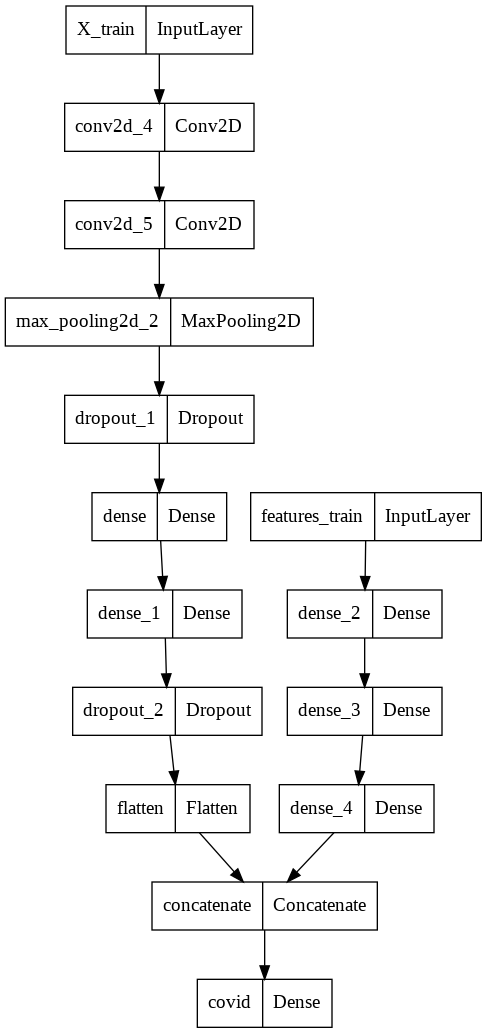

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 30, 901, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 28, 899, 32)  320         ['X_train[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 26, 897, 32)  9248        ['conv2d_4[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 13, 448, 32)  0          ['conv2d_5[0][0]']           

In [20]:
model.compile(optimizer = Adadelta(lr=2.0, rho=0.95, epsilon=None, decay=1e-4),
              loss = "binary_crossentropy", metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


In [21]:
model_path = "second-functional.h5"
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1, monitor = "val_loss")
es = EarlyStopping(patience=10, monitor = "val_loss")

In [22]:
hist = model.fit([X_train, features_train] , y_data_train,
                 epochs = 100, batch_size = 100,
                 validation_split=0.2, callbacks = [mc,es])

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.7909 - accuracy: 0.4932
Epoch 1: val_loss improved from inf to 0.69505, saving model to second-functional.h5
15/15 [==============================] - 8s 261ms/step - loss: 0.7909 - accuracy: 0.4932 - val_loss: 0.6951 - val_accuracy: 0.4824
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.5068
Epoch 2: val_loss improved from 0.69505 to 0.69270, saving model to second-functional.h5
15/15 [==============================] - 3s 177ms/step - loss: 0.6943 - accuracy: 0.5068 - val_loss: 0.6927 - val_accuracy: 0.5176
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5183
Epoch 3: val_loss did not improve from 0.69270
15/15 [==============================] - 3s 173ms/step - loss: 0.6930 - accuracy: 0.5183 - val_loss: 0.6943 - val_accuracy: 0.4824
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5183
Epoch 

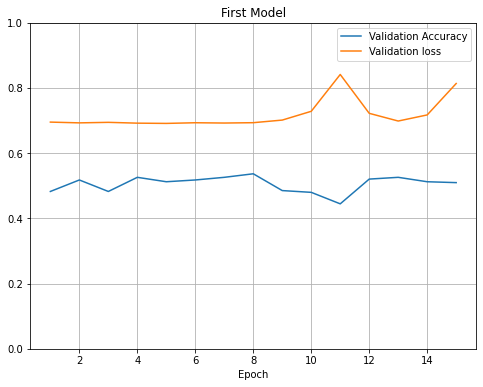

In [23]:
y_acc = hist.history["val_accuracy"]
y_vloss = hist.history["val_loss"]
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (8,6))
plt.plot(xs, y_acc, label = "Validation Accuracy")
plt.plot(xs, y_vloss, label = "Validation loss")
plt.legend(), plt.grid(), plt.xlabel("Epoch"), plt.title("First Model"), plt.ylim([0,1])
plt.show()

In [24]:
model = load_model(model_path)
model.evaluate([X_test, features_test], y_data_test)

15/15 [==============================] - 1s 25ms/step - loss: 0.6932 - accuracy: 0.4902


[0.693244218826294, 0.49023860692977905]